<a href="https://colab.research.google.com/github/mustafacavusoglu/Computer-Vision/blob/main/fc_densenet_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
torch.cuda.get_device_name()
torch.cuda.get_device_capability()

(7, 5)

In [ ]:
!nvidia-smi -L
!pip install gputil
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
print("GPU RAM Free: {0:.0f}MB | {1:} |Used: {2:.0f}MB | Util {3:3.0f}% | Total {4:.0f}MB".format(gpu.memoryFree,gpu.name, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))


GPU 0: Tesla T4 (UUID: GPU-0f62c884-b4b7-023d-bce3-5f8dd1c9e690)
GPU RAM Free: 15069MB | Tesla T4 |Used: 10MB | Util   0% | Total 15079MB


In [ ]:
# memory footprint support libraries/code


GPU RAM Free: 15069MB | Used: 10MB | Util   0% | Total 15079MB


In [ ]:
import os
# os.chdir("drive/MyDrive/ColabNotebooks/unet_uydu")
os.getcwd()

'/content/drive/My Drive/ColabNotebooks/unet_uydu/veriler'

In [ ]:
from __future__ import absolute_import
from __future__ import print_function

import keras.models as models
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import MaxPooling2D, UpSampling2D, Cropping2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Conv3D, Lambda
from keras import backend as K

from keras.models import Model
from keras.layers import Input, concatenate, Add
from keras.regularizers import l2
import json

In [ ]:
def BN_ReLU_Conv(inputs, n_filters, filter_size=3, dropout_p=0.2):
  img = BatchNormalization()(inputs)
  img = Activation('relu')(img)
  img = Conv2D(n_filters, filter_size, padding='same', kernel_initializer='he_uniform')(img)
  if dropout_p != 0.0:
      img = Dropout(dropout_p)(img)
  return img

def TransitionDown(inputs, n_filters, dropout_p=0.2):
  img = BN_ReLU_Conv(inputs, n_filters, filter_size=1, dropout_p=dropout_p)
  img = MaxPooling2D((2,2))(img)
  return img

def TransitionUp(skip_connection, block_to_upsample, n_filters_keep):
  
  img = Conv2DTranspose(n_filters_keep, kernel_size=3, strides=2, padding='same', kernel_initializer='he_uniform')(block_to_upsample)
  img = concatenate([img, skip_connection], axis=-1)
  return img

def SoftmaxLayer(inputs, n_classes):
    
  img = Conv2D(n_classes, kernel_size=1, padding='same', kernel_initializer='he_uniform')(inputs)
#    l = Reshape((-1, n_classes))(l)
  img = Activation('sigmoid')(img)
  return img

In [ ]:
def Tiramisu(
        input_shape=(512,512,3),
        n_classes = 2,
        n_filters_first_conv = 48,
        havuz_sayisi = 5,
        growth_rate = 12 ,
        block_sayisi = [5,5,5,5,5,12,5,5,5,5,5],
        dropout_p = 0.2
        ):
    
        
    #####################
    # First Convolution #
    #####################        
    inputs = Input(shape=input_shape)
    stack = Conv2D(filters=3, kernel_size=3, padding='same', kernel_initializer='he_uniform')(inputs)
    n_filters = 3*growth_rate

    #####################
# Downsampling path #
#####################     
    skip_connection_list = []
    
    for i in range(havuz_sayisi):
        for j in range(block_sayisi[i]):
            l = BN_ReLU_Conv(stack, growth_rate, dropout_p=dropout_p)
            stack = concatenate([stack, l])
            n_filters  += growth_rate
        skip_connection_list.append(stack)        
        stack = TransitionDown(stack, n_filters, dropout_p)
    skip_connection_list = skip_connection_list[::-1]

    
    #####################
    #    Bottleneck     #
    #####################     
    block_to_upsample=[]
    
    for j in range(block_sayisi[havuz_sayisi]):
        l = BN_ReLU_Conv(stack, growth_rate, dropout_p=dropout_p)
        block_to_upsample.append(l)
        stack = concatenate([stack,l])
    block_to_upsample = concatenate(block_to_upsample)

   
    #####################
    #  Upsampling path  #
    #####################
    for i in range(havuz_sayisi):
        n_filters_keep = growth_rate * block_sayisi[havuz_sayisi + i ]
        stack = TransitionUp(skip_connection_list[i], block_to_upsample, n_filters_keep)
        
        block_to_upsample = []
        for j in range(block_sayisi[ havuz_sayisi + i + 1 ]):
            l = BN_ReLU_Conv(stack, growth_rate, dropout_p=dropout_p)
            block_to_upsample.append(l)
            stack = concatenate([stack, l])
        block_to_upsample = concatenate(block_to_upsample)
    
    #####################
    #  Softmax          #
    #####################
    output = SoftmaxLayer(stack, n_classes)            
    model=Model(inputs = inputs, outputs = output)    
    # model.summary()
    
    return model

In [ ]:
fcDensenet = Tiramisu()
#fcDensenet.summary()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#os.chdir("veriler")
train_x= np.load('train_images.npy')
train_y= np.load('train_labels.npy')

val_x= np.load('validation_images.npy')
val_y= np.load('validation_labels.npy')


print(val_x.shape)
print(val_y.shape)

(93, 512, 512, 3)
(93, 512, 512, 2)


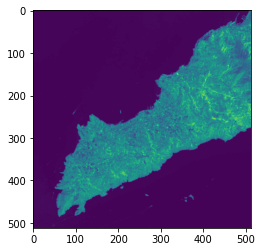

In [ ]:
img = train_x[4,:,:,0]
img1 = val_x[1,:,:,0]

plt.imshow(img1)
# plt.imshow(img1)


In [ ]:
from keras.optimizers import RMSprop
optimizer = RMSprop(learning_rate=0.0002)
fcDensenet.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
nb_epoch = 10
batch_size = 2


history = fcDensenet.fit(train_x, train_y, 
                 batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1,
                 validation_data=(val_x, val_y)
                 )

Epoch 1/10
413/413 [==============================] - 356s 863ms/step - loss: 21.9243 - accuracy: 0.9539 - val_loss: 2.2598 - val_accuracy: 0.9546
Epoch 2/10
413/413 [==============================] - 355s 859ms/step - loss: 1.7016 - accuracy: 0.9863 - val_loss: 2.2044 - val_accuracy: 0.9693
Epoch 3/10
413/413 [==============================] - 355s 860ms/step - loss: 1.3727 - accuracy: 0.9872 - val_loss: 1.4143 - val_accuracy: 0.9551
Epoch 4/10
413/413 [==============================] - 355s 860ms/step - loss: 1.2525 - accuracy: 0.9862 - val_loss: 1.3314 - val_accuracy: 0.9760
Epoch 5/10
413/413 [==============================] - 355s 860ms/step - loss: 1.1682 - accuracy: 0.9886 - val_loss: 1.0932 - val_accuracy: 0.9728
Epoch 6/10
413/413 [==============================] - 356s 861ms/step - loss: 1.1028 - accuracy: 0.9869 - val_loss: 0.9873 - val_accuracy: 0.9737
Epoch 7/10
413/413 [==============================] - 356s 861ms/step - loss: 1.0142 - accuracy: 0.9882 - val_loss: 0.9531 

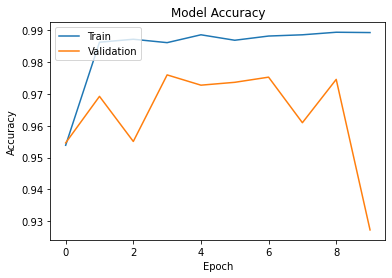

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


In [ ]:
os.chdir("../testsonuclardensenet")
import csv
import keras
from keras.models import model_from_json
from sklearn.utils import class_weight

In [ ]:
import cv2
os.chdir('../veriler')
test_name_ALL = 'test_images_labels.csv'
test_list = []     

with open(test_name_ALL, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        test_list.append(row)   

test_x= np.load('test_images.npy')
os.chdir('../testsonuclardensenet')
os.getcwd()

deneme = list(range(test_x.shape[0]-1))
for i in deneme:
    A = np.zeros((1,512,512,3))
    A[0,:,:,:] = test_x[i,:,:,:]
    B = fcDensenet.predict(A)
    C = B[:,:,:,0]
    D = C>0.5
    D = D[0,:,:]
    isim = 'sonuc_' + "densenet" + '_' +str(test_list[i]) + '.tif'
    cv2.imwrite(isim, 255*D)